### Task 1: Import Libraries

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
#import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

from pandas_profiling import ProfileReport

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Task 2: Exploratory Data Analysis

In [3]:
hr = pd.read_csv('data/employee_data.csv')
hr_orig = hr
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
pr=ProfileReport(hr,title="pandas_profiling_results",explorative=True)
pr

### Task 3: Encode Categorical Features

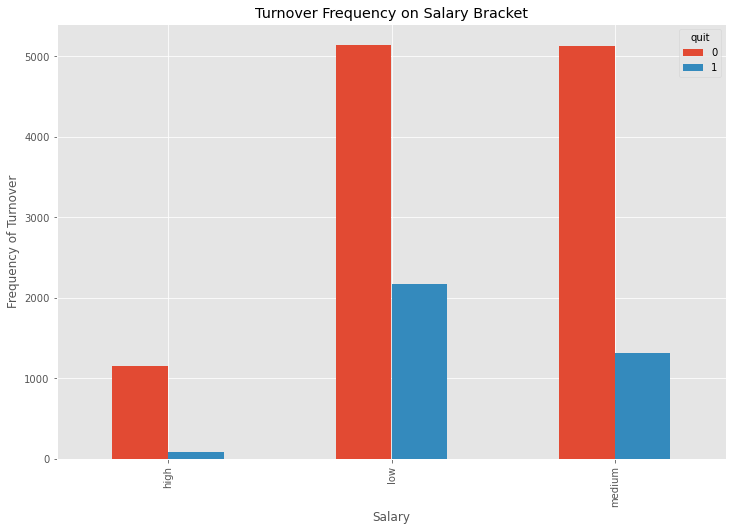

In [6]:
pd.crosstab(hr.salary,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency on Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

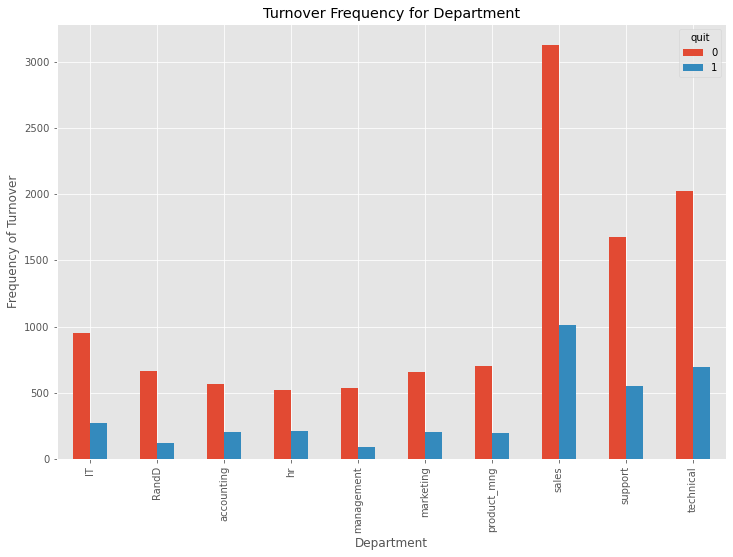

In [7]:
pd.crosstab(hr.department,hr.quit).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

In [9]:
cat_vars=['department','salary']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr1=hr.join(cat_list)
    hr=hr1
    
#after this step we need to drop the extra cols, original df cols

ValueError: columns overlap but no suffix specified: Index(['department_IT', 'department_RandD', 'department_accounting',
       'department_hr', 'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical'],
      dtype='object')

In [10]:
hr.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'quit',
       'promotion_last_5years', 'department', 'salary', 'department_IT',
       'department_RandD', 'department_accounting', 'department_hr',
       'department_management', 'department_marketing',
       'department_product_mng', 'department_sales', 'department_support',
       'department_technical', 'salary_high', 'salary_low', 'salary_medium'],
      dtype='object')

In [11]:
hr.drop(columns=['department','salary'], axis=1, inplace=True)
#hr.drop(hr.columns[[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]], axis=1, inplace=True)

### Task 4: Visualize Class Imbalance

In [15]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

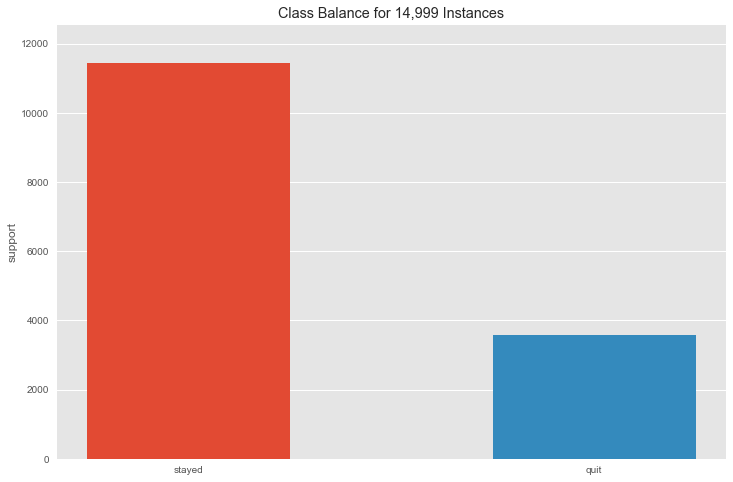

In [16]:
visualizer = ClassBalance(labels=["stayed", "quit"])

visualizer.fit(hr.quit)
visualizer.show();

#idk why this part is needed u can use barplot as well however we can see that we have a class imbalance problem thus
#we should use stratifiedsampling on train and test(validation) set.

### Task 5: Create Training and Test Sets

In [17]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    stratify=y)

### Task 6 :Build an Interactive Decision Tree Classifier

- Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high var

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [20]:
@interact
def plot_tree(crit=["gini", "entropy"],
              split=["best", "random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = DecisionTreeClassifier(random_state=0,
                                       criterion=crit,
                                       splitter = split,
                                       max_depth = depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))

    graph = Source(tree.export_graphviz(estimator,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

#to convert any func into an interactive one u can use @interact decorator (its a func decorator) IMMEDIATLY before func.
#we select just a small portion of parameters as interactive. u could add more widgets as well.

#1st arg is a criteria, gini or entropy, basically its a method for how to create yr dt. this "[]" format creates dropdown.
#2nd arg is a split, best or random.choice btw best split or randomizing the split.

#next we need to create our sliders. they are 3rd arg. we will use IntSlider from ipwidget for this. min slider val, max sldr
#val,and initial slider val (value) and cont_update means it ll be updated w new parameter if u release the mouse.

#4th arg is min_split.its min # of samples required to split a node.
#5th one is min_leaf. min # of samples required to add a leaf node.then we add all 5 of these widgets 2 our model on nxt line


#graph part is for visualization. u need to add yr model,also we dont want output file, feature_names should be defined to
#be seen on dt nodes. class_names is label_names. filled colors the nodes based on majority of class labels.


#we only need to call display func from jupyter, to display this effort to the screen.we want to display an "Image" and we're
#getting our data from the graph we generated early. and that ".pipe" part is for image format which is png. it could be sth
#else.

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [21]:
#1 problem with dts is, they have low bias but high variance. so they tend to overfit. so its time for rand forest classifier

### Task 7: Build an Interactive Random Forest Classifier

Although randomization inc bias, it is possible to get a red in var of the model. random forests are robust machine learning algorithms for a variety of reasons:

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [22]:
@interact
def plot_tree_rf(crit=["gini", "entropy"],
                 bootstrap=["True", "False"],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                      verbose=False).fit(X_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\nVisualizing Decision Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled = True))
    
    display(Image(data=graph.pipe(format='png')))
    
    return estimator

#there is 1 important difference here and its num_tree part. bcs rf uses many trees, its not very meaningful to print all
#trees into 1 visual, thus we select 1 tree from the entire forest to print.we choose 1st tree.

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 9: Feature Importance and Evaluation Metrics

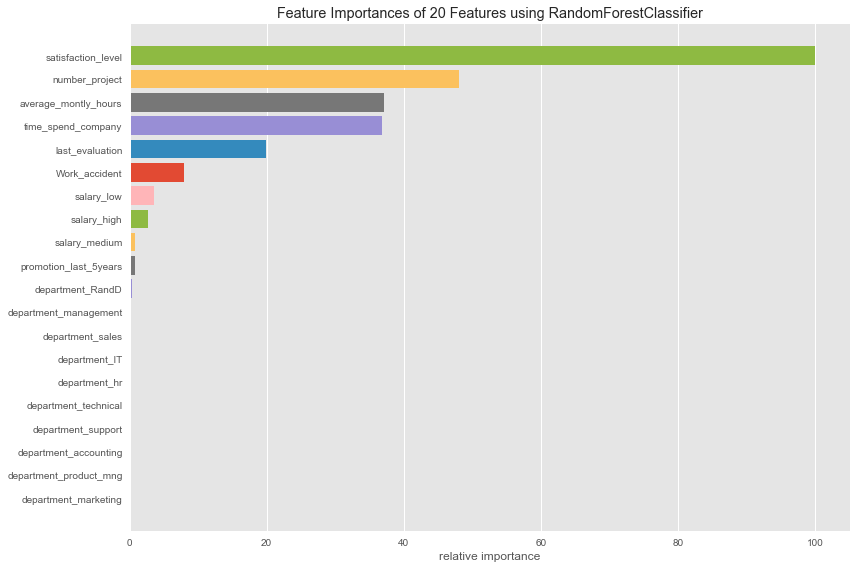

In [23]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show()

#teacher does couple of sliding on rf model and find a good model then literally c/v its model specs and then follow 2-3 line
#procedure and thats it

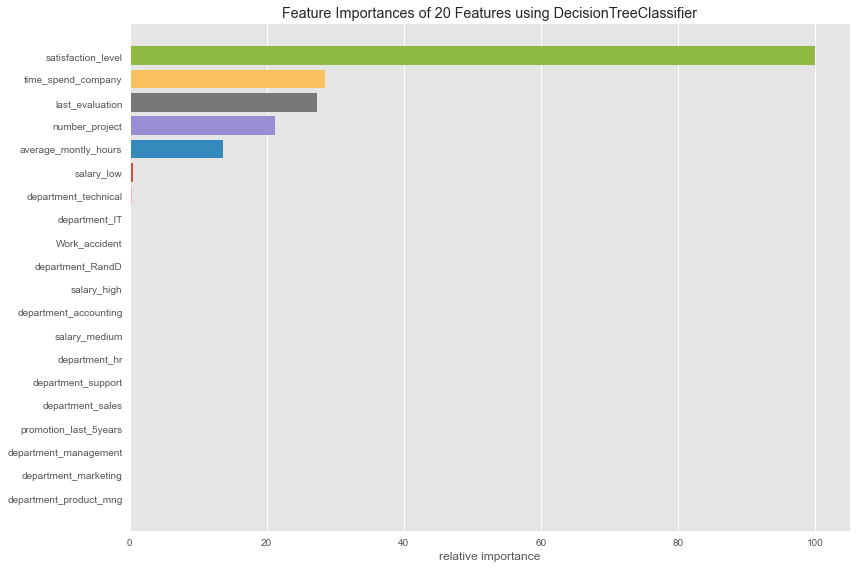

In [24]:
#u can also see what dt thinks, ofc rf almost always has better models.

dt=DecisionTreeClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=4,
                       random_state=0)

viz=FeatureImportances(dt)
viz.fit(X_train,y_train)
viz.show()

#as u can see we have dif sets of imp features here w dif percentages.

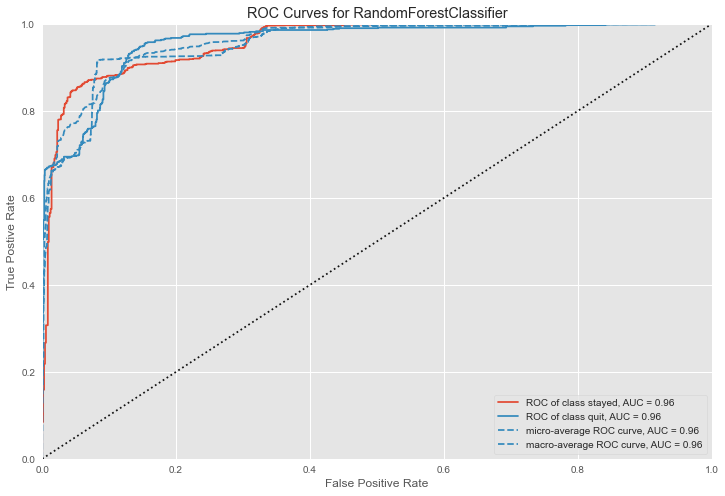

In [25]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
#visualizer.poof(); this is memeing code. it ll also work as visualizer.show() however it also has wizard of oz reference..
visualizer.show()

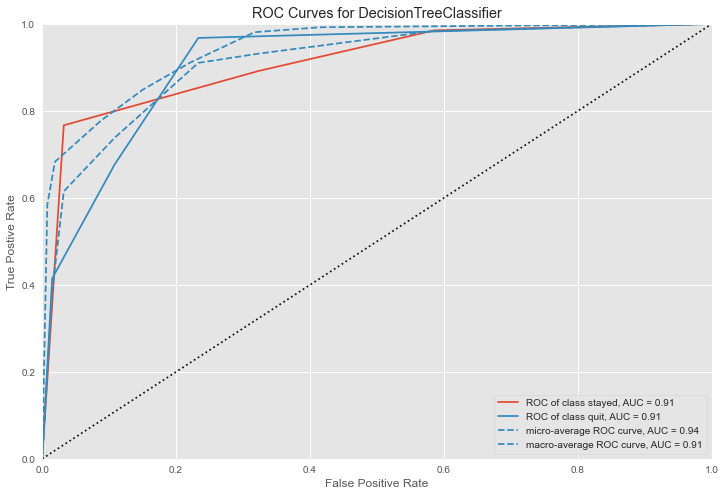

In [26]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

visualizer = ROCAUC(dt, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
#visualizer.poof();
visualizer.show()

### Comparing Ensemble Model w Logistic Regression

Logistic Regression Accuracy: 0.792


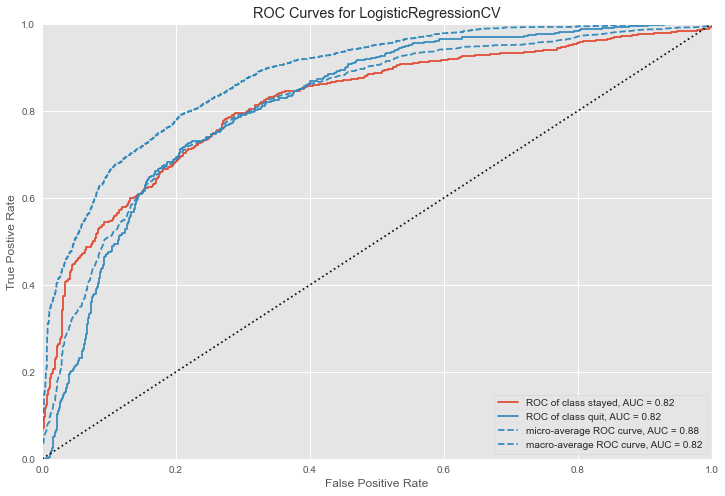

In [27]:
from sklearn.linear_model import LogisticRegressionCV

logit = LogisticRegressionCV(random_state=1, n_jobs=-1,max_iter=500,
                             cv=10)

lr = logit.fit(X_train, y_train)

print('Logistic Regression Accuracy: {:.3f}'.format(accuracy_score(y_test, lr.predict(X_test))))

visualizer = ROCAUC(lr, classes=["stayed", "quit"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
#visualizer.poof();
visualizer.show()

#if u would ask "what about logreg? here is an answer."
#also learning yellowbrick is extremely efficient way of working as datascientist